что возможно:в текстовые признаки очистить и выделить токены (+стемминг, леммитизацию), попробовать использовать word2vec или тем. моделирование для описания, подобрать параметры для tf-idf и svd, лучше извлечь признаки из display_adress или street_adress. посчитать расстояние между display_adress и street_adress
обучить нн на фото и использовать веса с выхода предпоследних слоев, проверить дубликаты среди изображений, попробовать фичи на основе knn или кластеризации, перекодировать через таргет
стекинг, ансамбли, автомл

https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection 

https://www.kaggle.com/camnugent/geospatial-feature-engineering-and-visualization

https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-2-connect

https://www.kaggle.com/neviadomski/data-exploration-two-sigma-renthop

In [0]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile
%cd ..
%cd ..

fatal: destination path 'LightGBM' already exists and is not an empty directory.
/content/LightGBM
mkdir: cannot create directory ‘build’: File exists
-- Found OpenMP_C: -fopenmp  
-- Found OpenMP_CXX: -fopenmp  
-- Found OpenMP: TRUE   
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   filesystem
--   system
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/LightGBM
[100%] Built target lightgbm
[100%] Built target _lightgbm
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (46.1.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)
Requirement already

In [0]:
!pip install flashtext 
from flashtext.keyword import KeywordProcessor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np 
import pandas as pd 
import os
import json
import lightgbm as lgbm
from zipfile import ZipFile
import warnings
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import StratifiedKFold
import functools
warnings.filterwarnings('ignore')

In [0]:
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))


with ZipFile('train.json.zip') as myzip:
    with myzip.open('train.json', 'r') as raw_data:
        train = pd.DataFrame(json.load(raw_data))
    
with ZipFile('test.json.zip') as myzip:
    with myzip.open('test.json', 'r') as raw_data:
        test = pd.DataFrame(json.load(raw_data))
        
print(f'train shape: {train.shape} \ntest shape: {test.shape}')

train shape: (49352, 15) 
test shape: (74659, 14)


In [0]:
class Dataset:
    def __init__(self, train, test):
        self._train = train
        self._test = test
        
    @property
    def train(self):
        return self._train
    
    @property
    def test(self):
        return self._test
    
    @property
    def all(self):
        return pd.concat([self._train, self._test], ignore_index = True)

train.interest_level = train.interest_level.map(
    {'low': 1,
     'medium': 2,
     'high': 3}
)        
data = Dataset(train, test)

del train, test

In [0]:
data.train.info(), data.test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 6.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 74659 

(None, None)

In [0]:
data.train.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,2
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,1
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,2
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,2
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,1


In [0]:
data.train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level'],
      dtype='object')

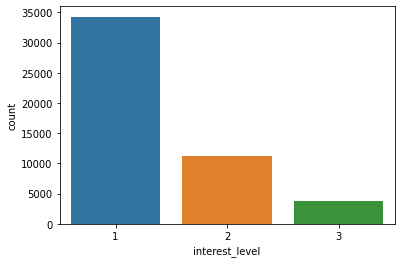

In [0]:
sns.countplot(data.train.interest_level);

In [0]:
#отсутсвующие значения
pd.DataFrame({
    'train': data.train.isnull().sum(),
    'test': data.test.isnull().sum()}).T

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
data.train.created = pd.to_datetime(data.train.created)
data.test.created = pd.to_datetime(data.test.created)

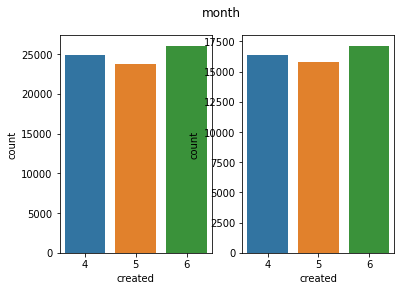

In [0]:
plt.suptitle('month')
plt.subplot(121)
sns.countplot(data.test.created.dt.month,  label = 'train')
plt.subplot(122) 
sns.countplot(data.train.created.dt.month, label = 'test');

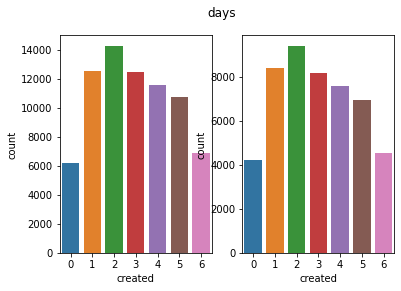

In [0]:
plt.suptitle('days')
plt.subplot(121)
sns.countplot(data.test.created.dt.dayofweek, label = 'train')
plt.subplot(122)
sns.countplot(data.train.created.dt.dayofweek, label = 'test');

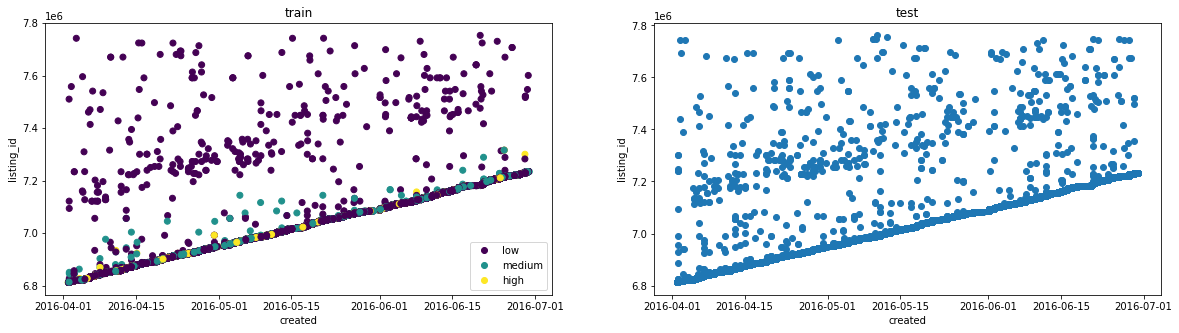

In [0]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
scatter = plt.scatter(data.train.created, data.train.listing_id, c = data.train.interest_level)
plt.title('train')
plt.legend(handles = scatter.legend_elements()[0], labels = ['low', 'medium', 'high'])
plt.xlabel('created')
plt.ylabel('listing_id')
plt.subplot(122)
plt.scatter(data.test.created, data.test.listing_id)
plt.title('test')
plt.xlabel('created')
plt.ylabel('listing_id');
#чем дальше день от минимального created, тем больше listingid, близко к линейности, и часть low хорошо отделяется

In [0]:
len(data.all.created) - len(data.all.created.unique())

4289

In [0]:
group_created = data.all.groupby('created').price.count()
group_created[group_created > 1].sort_values()

created
2016-04-02 01:14:46    2
2016-06-03 02:23:07    2
2016-06-03 02:29:48    2
2016-06-03 02:31:17    2
2016-06-03 02:38:58    2
                      ..
2016-06-12 13:43:27    4
2016-06-21 04:23:01    4
2016-05-11 05:13:41    4
2016-05-18 01:36:49    4
2016-06-11 03:22:50    4
Name: price, Length: 4069, dtype: int64

In [0]:
def prev_date(manager_id, date):
    dates = data.all[data.all.manager_id == manager_id][['created', 'price']].sort_values(by = 'created')
    dates['shift_dates'] = dates.created.shift(1)
    dates['shift_dates'] = dates.shift_dates.fillna(dates.created.min())
    return (date - dates[dates.created == date].shift_dates.values[0]).total_seconds()

In [0]:
%%time

start_date = data.all.groupby('manager_id').created.min()
start_date_min = data.all.created.min()

for df in [data.train, data.test]:
    df['day'] = df.created.dt.dayofweek
    df['month'] = df.created.dt.month
    df['is_weekend'] = df.day.apply(lambda x: 1 if (x == 5) or (x == 6) else 0)
    df['count_date'] = df.created.map(group_created.to_dict()) #кол-во дат
    df['is_uniq_date'] = (df.count_date != 1).astype(np.uint8) #уникальна ли дата
    #кол-во секунд прошедшего с первого объявления к менеджеру(по конкретному менеджеру)
    df['time_from_first_created_per_manager'] = df[['manager_id', 'created']].apply(lambda x: (x.created - start_date.get(x.manager_id)).total_seconds(), axis = 1)
    #кол-во секунд прошедших с первого объявления к менеджерам(по всем менеджерам) 
    df['time_from_first_created'] = df.created.apply(lambda x: (start_date_min - x).total_seconds())
    #кол-во сек с предидущего создания объвления
    #df['time_form_prev_created'] = df[['manager_id', 'created']].apply(lambda x: prev_date(x.manager_id, x.created), axis = 1)

CPU times: user 12.7 s, sys: 54.9 ms, total: 12.8 s
Wall time: 12.8 s


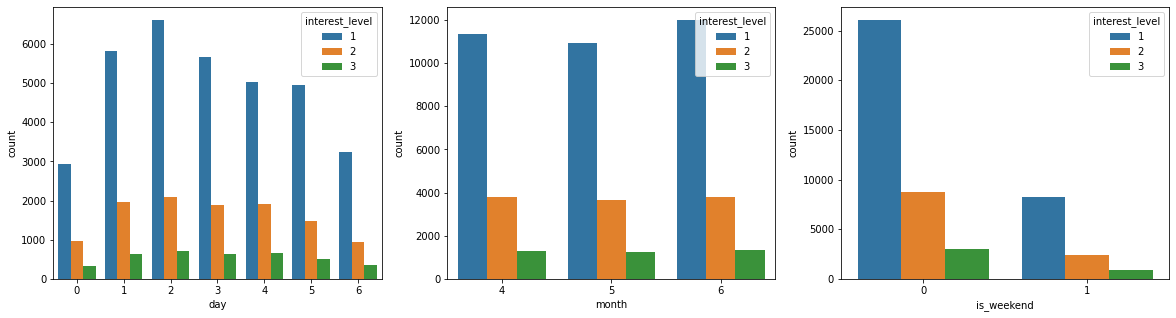

In [0]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
sns.countplot(x = 'day', data = data.train, hue = 'interest_level')
plt.subplot(132)
sns.countplot(x = 'month', data = data.train, hue = 'interest_level')
plt.subplot(133)
sns.countplot(x = 'is_weekend', data = data.train, hue = 'interest_level');

In [0]:
print('уникальных в трейне listing id: ', len(data.train.listing_id.unique()))
print('уникальных в трейне manager_id: ', len(data.train.manager_id.unique())) 
print('уникальных в трейне building_id: ', len(data.train.building_id.unique())) 

уникальных в трейне listing id:  49352
уникальных в трейне manager_id:  3481
уникальных в трейне building_id:  7585


In [0]:
print('кол-во пересечений listing_id трейна с тестом : ', data.test.listing_id.isin(data.train.listing_id.unique()).sum())
print('кол-во пересечений manager_id трейна с тестом : ', data.test.manager_id.isin(data.train.manager_id.unique()).sum())
print('кол-во пересечений building_id трейна с тестом : ',data.test.building_id.isin(data.train.building_id.unique()).sum())

кол-во пересечений listing_id трейна с тестом :  0
кол-во пересечений manager_id трейна с тестом :  73185
кол-во пересечений building_id трейна с тестом :  69041


In [0]:
print('уникальных в тесте listing_id: ', len(data.test[~data.test.listing_id.isin(data.train.listing_id.unique())].listing_id.unique()))
print('уникальных в тесте manager_id: ', len(data.test[~data.test.manager_id.isin(data.train.manager_id.unique())].manager_id.unique()))
print('уникальных в тесте building_id: ', len(data.test[~data.test.building_id.isin(data.train.building_id.unique())].building_id.unique()))

уникальных в тесте listing_id:  74659
уникальных в тесте manager_id:  918
уникальных в тесте building_id:  4050


In [0]:
data.all[data.all.building_id == '0'][['building_id', 'manager_id', 'display_address']].head(5)
#разные значения

,building_id,manager_id,display_address
19,0,e6ecf676c4359ad2903283834f1fd301,Main Street
26,0,26d69329a0f3b9abecbddd6abcb5b622,Cliff Street
38,0,929baf387cf71d98482a9743ab8a0890,President St.
43,0,befc71000fbd97ffe17b1ef8566b0590,East 12th Street
49,0,4e5304f1a81d01dc91dd05d9209713ac,East 68th Street


In [0]:
len(data.train.display_address.unique()), len(data.train.street_address.unique()) 

(8826, 15358)

In [0]:
#кол-во менеджеров на здание и кол-во зданий на менеджера
count_man_per_build = data.all.groupby('building_id').manager_id.unique().apply(len).to_dict()
count_build_per_man = data.all.groupby('manager_id').building_id.unique().apply(len).to_dict()

for df in [data.train, data.test]:
    df['count_photos'] = df.photos.apply(len)
    df['count_photos_is_0'] = (df.count_photos == 0).astype(np.uint8)
    df['count_features'] = df.features.apply(len)
    df['count_features_is_0'] = (df.count_features == 0).astype(np.uint8)

    #признаки с manager_id
    df['count_uniq_build_in_manage'] = df.manager_id.map(count_build_per_man) #кол-во зданий на менеджера
    df['mean_price_manager'] = df.manager_id.map(data.all.groupby('manager_id').price.mean().to_dict()) #средняя стоимость у менеджера
    df['max_price_manager'] = df.manager_id.map(data.all.groupby('manager_id').price.max().to_dict())
    df['mim_price_manager'] = df.manager_id.map(data.all.groupby('manager_id').price.min().to_dict())
    df['median_price_manager'] = df.manager_id.map(data.all.groupby('manager_id').price.median().to_dict())
    df['unique_display_adress_per_manager'] =  df.manager_id.map(data.all.groupby('manager_id').display_address.unique().apply(len).to_dict()) #кол-во уникальных улиц с которыми работаем менеджер
    df['total_offer_per_manager'] = df.manager_id.map(data.all.groupby('manager_id').listing_id.count().to_dict())
    df['estimate_price_from_manager_id'] = df.price / df.mean_price_manager #отношение цены к средней цену менеджера
    df['price_minum_mean_manager_id'] = df.price - df.mean_price_manager
    df['price_minus_median_manager_id'] = df.price - df.median_price_manager


    #признаки с building_id 
    df['building_id_is_0'] = (df.building_id == '0').astype(np.uint8)
    df['count_uniq_manage_in_build'] = df.building_id.map(count_man_per_build) #кол-во менеджеров в здании
    df['mean_price_in_build'] = df.building_id.map(data.all.groupby('building_id').price.mean().to_dict())
    df['median_price_in_build'] = df.building_id.map(data.all.groupby('building_id').price.median().to_dict())
    df['max_price_in_build'] = df.building_id.map(data.all.groupby('building_id').price.max().to_dict())
    df['min_price_in_build'] = df.building_id.map(data.all.groupby('building_id').price.min().to_dict())
    df['total_offer_per_build'] = df.building_id.map(data.all.groupby('building_id').listing_id.count().to_dict())
    df['estimate_price_from_build_id'] = df.price / df.mean_price_in_build #отношение цены к средней цену менеджера
    df['price_minum_mean_build_id'] = df.price - df.mean_price_in_build 
    df['price_minus_median_build_id'] = df.price - df.median_price_in_build


    #признаки из description
    df['count_words_in_desc'] = df.description.apply(lambda s: len(s.split(' '))) #кол-во слов в описании ДОРАБОТАТЬ УБРАВ СТОП СЛОВА
    df['count_words_capslock'] = df.description.apply(lambda s: len([w for w in s.split(' ') if w.isupper()])) #слов капом в описании
    df['office_in_desc'] = df.description.apply(lambda s: 1 if 'office' in s.lower() else 0)#в описании слово офис
    df['studio_in_desc'] = df.description.apply(lambda s: 1 if 'studio' in s.lower() else 0)#в описании слово студия
    df['empty_desc'] = df.description.apply(lambda s: 1 if s.strip() == '' else 0)#пустое описание
    df['transport_desc'] = df.description.apply(lambda s: sum([(val in s.lower()) for val in ['taxi', 'bus', 'subway', 'underground']]))#транспорт в описании
    
    #признаки display_adress
    df['count_numeric_in_display_adress'] = df.display_address.apply(lambda s: len(re.findall('(\d+)', s))) #Кол-во цифр
    df['count_managers_per_display_adress'] = df.display_address.map(data.all.groupby('display_address').manager_id.count().to_dict())#количество менеджеров на улицу
    df['unq_count_managers_per_display'] = df.display_address.map(data.all.groupby('display_address').manager_id.unique().apply(len).to_dict()) #уникальных менеджеров
    df['mean_price_per_display_adress'] = df.display_address.map(data.all.groupby('display_address').price.mean().to_dict())#средняя цена
    df['median_price_per_display_adress'] = df.display_address.map(data.all.groupby('display_address').price.median().to_dict())#медианная цена
    df['min_price_per_display_adress'] = df.display_address.map(data.all.groupby('display_address').price.min().to_dict())
    df['max_price_per_display_adress'] = df.display_address.map(data.all.groupby('display_address').price.max().to_dict())
    df['count_build_per_display_adress'] = df.display_address.map(data.all.groupby('display_address').building_id.count().to_dict())#количество домов на улицу
    df['unq_count_build_per_display'] = df.display_address.map(data.all.groupby('display_address').building_id.unique().apply(len).to_dict()) #уникальных домов
    df['total_offer_per_display_adress'] = df.display_address.map(data.all.groupby('display_address').listing_id.count().to_dict())#общее кол-во предложений
    df['estimate_price_from_display_adress'] = df.price / df.mean_price_per_display_adress #отношение цены к средней цeне из display adress
    df['price_minum_mean_display_adress'] = df.price - df.mean_price_per_display_adress
    df['price_minus_median_display_adress'] = df.price - df.median_price_per_display_adress

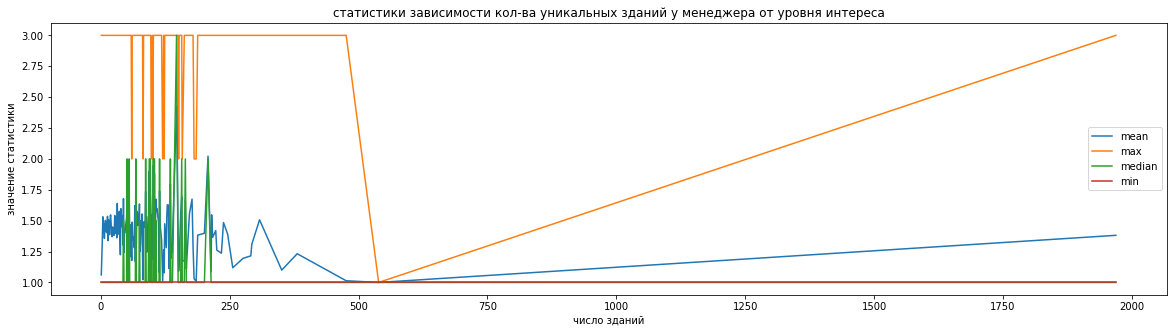

In [0]:
#зависимость менеджера от кол-ва зданий 
_data_for_plot = data.train.groupby('count_uniq_build_in_manage').interest_level.agg(['mean', 'max', 'median', 'min'])
plt.figure(figsize = (20, 5))
for col in _data_for_plot: plt.plot(_data_for_plot.index, _data_for_plot[col], label = col)
plt.title('статистики зависимости кол-ва уникальных зданий у менеджера от уровня интереса')
plt.xlabel('число зданий')
plt.ylabel('значение статистики')
plt.legend();

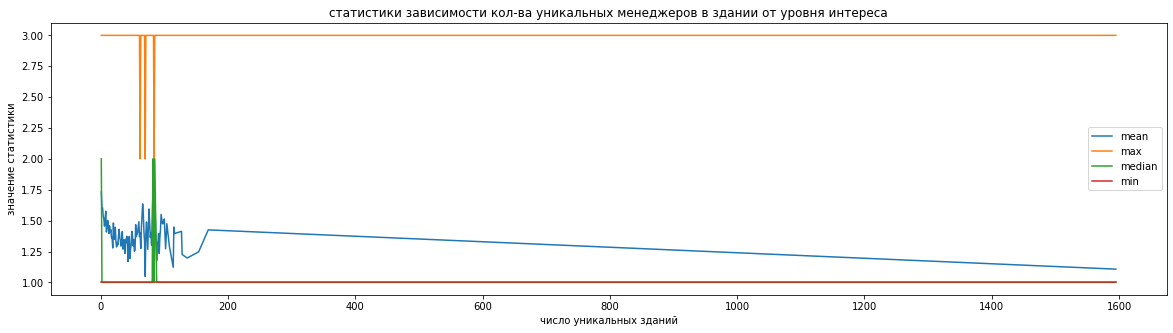

In [0]:
#зависимость оценки зданий от кол-ва менеджеров 
_data_for_plot = data.train.groupby('count_uniq_manage_in_build').interest_level.agg(['mean', 'max', 'median', 'min'])
plt.figure(figsize = (20, 5))
for col in _data_for_plot: plt.plot(_data_for_plot.index, _data_for_plot[col], label = col)
plt.title('статистики зависимости кол-ва уникальных менеджеров в здании от уровня интереса')
plt.xlabel('число уникальных зданий')
plt.ylabel('значение статистики')
plt.legend();

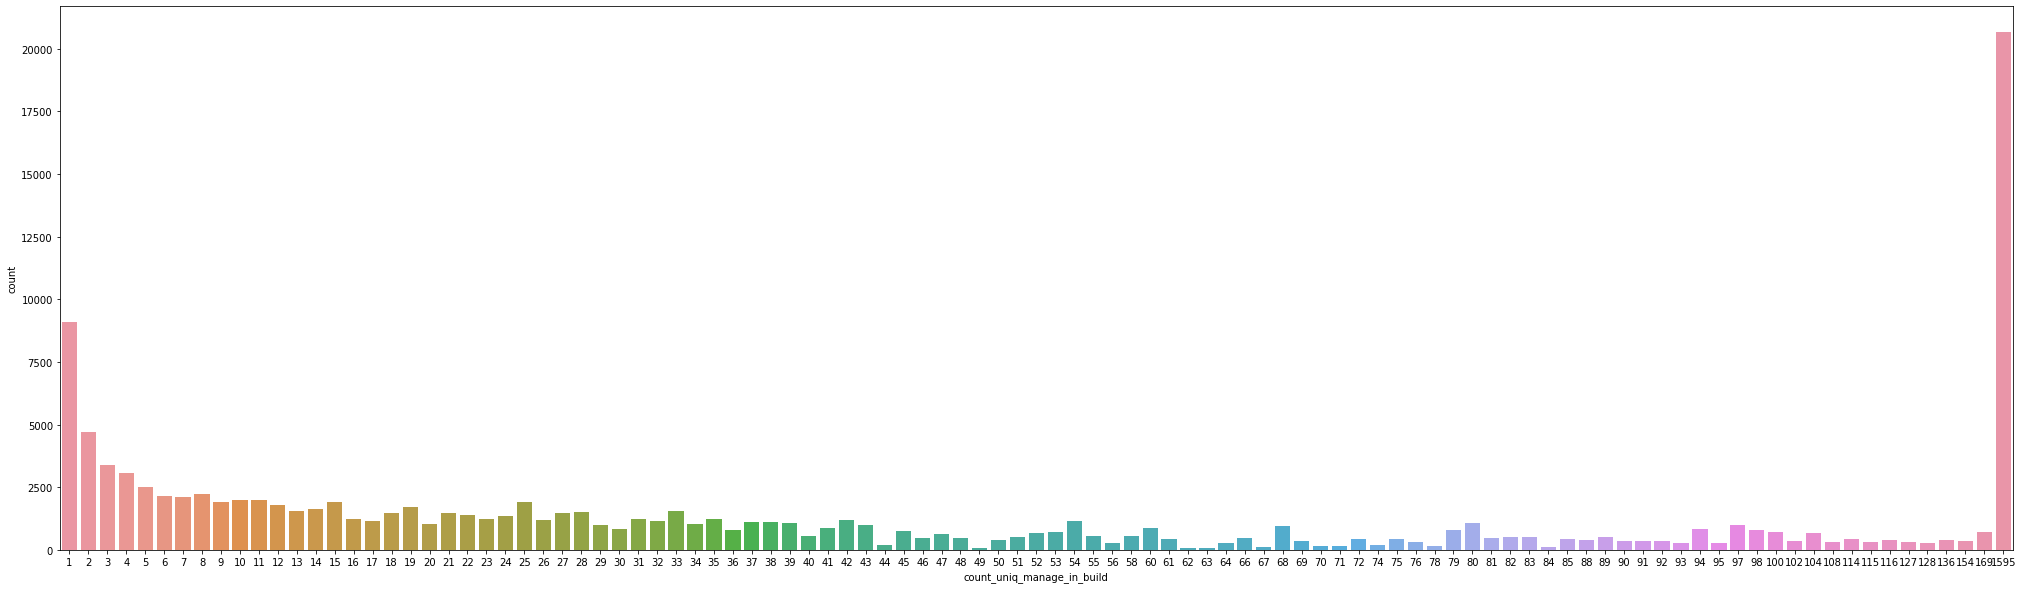

In [0]:
plt.figure(figsize = (35, 10))
sns.countplot(data.all.count_uniq_manage_in_build);

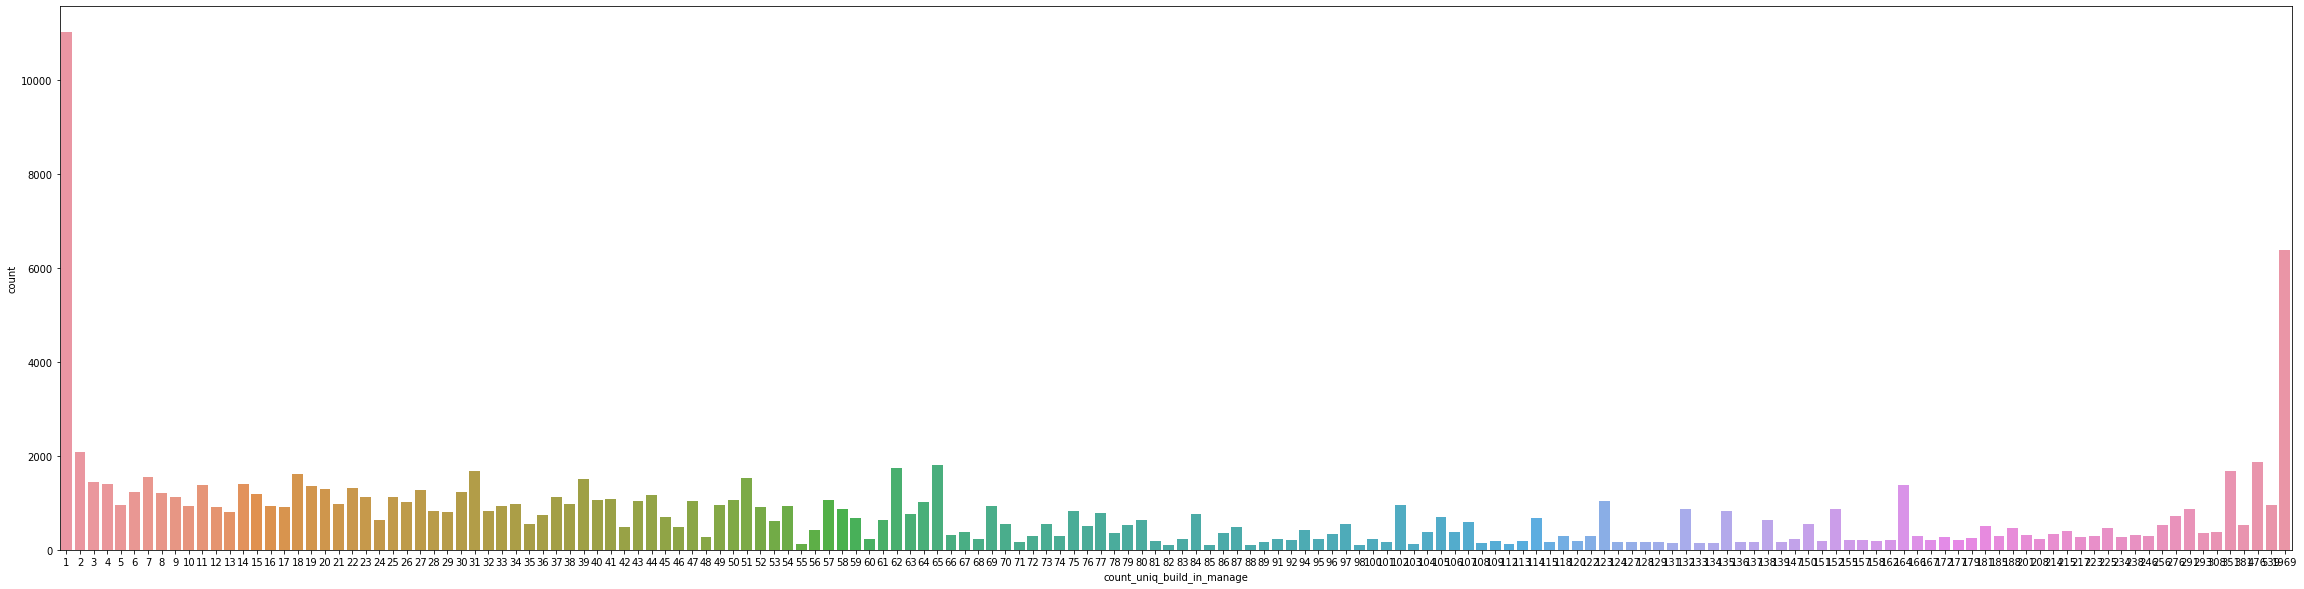

In [0]:
plt.figure(figsize = (40, 10))
sns.countplot(data.all.count_uniq_build_in_manage);

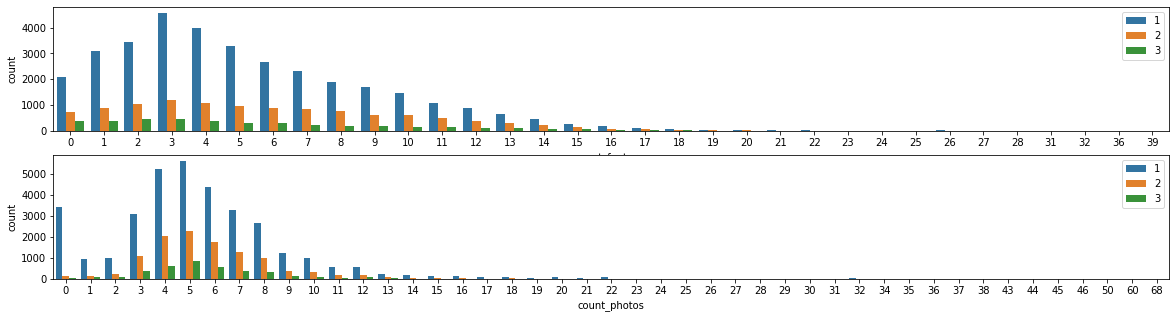

In [0]:
plt.figure(figsize = (20, 5))
plt.subplot(211)
sns.countplot(x = 'count_features', data = data.train, hue = 'interest_level')
plt.legend(loc = 'upper right')
plt.subplot(212)
sns.countplot(x = 'count_photos', data = data.train, hue = 'interest_level')
plt.legend(loc = 'upper right');

In [0]:
#5я Авеню делит Манхэттен на восточную и западную часть      
for df in [data.train, data.test]:
    df.street_address = df.street_address.apply(lambda s: re.sub(' E ', ' east ', s))
    df.street_address = df.street_address.apply(lambda s: re.sub(' W ', ' west ', s))
    for col in 'west east'.split(' '):
        df[f'is_{col}'] = df.street_address.apply(lambda s:1 if f' {col} ' in s.lower() else 0)


#street - наличие домов и др. зданий
#avenue - перпендекулярно street наличеие домов и деревьев
#place - дорога или улица с тупиков
#terrace - улица ведущая вниз по склону
#lane - узкая дорога в спальном р-не или поселке с частными домами
#drive - дорога пролеженная вдоль географического объекта
#crescent = - извилистая узкая дорога, которая соединяется с другими дорогами с двух концов
#court - небольшая улица в жил. квартале, вещущая в тупик
#boulevard - большая улица с несколькими полосами для движения с деревьями по бокам и большая разд. полосой полосой
#road
#broadway - старейшая из крупных улиц Нью-Йорка
for df in [data.train, data.test]:
    df.street_address = df.street_address.apply(lambda s: re.sub('street', ' st', s.lower().replace('.', ' ')))
    df.street_address = df.street_address.apply(lambda s: re.sub('avenue', ' ave', s.lower().replace('.', ' ')))
    df.street_address = df.street_address.apply(lambda s: re.sub('place', ' pl', s.lower().replace('.', ' ')))
    for col in 'st ave pl lane terrace drive crescent court boulevard road broadway'.split(' '):
        if col == 'st': 
            df[f'is_st'] = df.street_address.apply(lambda s:1 if (' st' in s) or (s.endswith('th')) else 0)
        else:
            df[f'is_{col}'] = df.street_address.apply(lambda s:1 if f' { col}' in s else 0)

In [0]:
cols = 'st ave pl lane terrace drive crescent court boulevard road broadway west east'.split(' ')
data.train[[f'is_{col}' for col in cols]].sum().T

is_st           36767
is_ave           8048
is_pl            1094
is_lane           158
is_terrace        190
is_drive          131
is_crescent       134
is_court           56
is_boulevard      278
is_road           149
is_broadway       540
is_west         12514
is_east         15503
dtype: int64

In [0]:
idx2nob = {'index': 'bathrooms'}
bathrooms = pd.DataFrame({
    'count_train': data.train.bathrooms.value_counts(),
    'count_test': data.test.bathrooms.value_counts()}).reset_index().rename(idx2nob, axis = 1)

tr_stats_of_bathrooms_for_price = data.train.groupby('bathrooms')['price'].agg(['mean', 'max', 'min', 'median']).reset_index()
ts_stats_of_bathrooms_for_price = data.test.groupby('bathrooms')['price'].agg(['mean', 'max', 'min', 'median']).reset_index()                                                                                                                                

bathrooms.merge(tr_stats_of_bathrooms_for_price.merge(ts_stats_of_bathrooms_for_price, 
                                                      on = 'bathrooms', how = 'outer', suffixes = ('_train', '_test')), 
                on = 'bathrooms', how = 'outer')

#необычно, что число ванных не int, присутсвуют 0 и  числа типа 112
#возможно ввести признак отделяющий bathrooms == 1 и остальные обработать странные значения

,bathrooms,count_train,count_test,mean_train,max_train,min_train,median_train,mean_test,max_test,min_test,median_test
0,0.0,313.0,474.0,4001.530351,135000.0,868.0,2700.0,3587.324895,58333.0,907.0,2695.0
1,1.0,39422.0,59664.0,3233.940490,4490000.0,43.0,2900.0,3149.989625,1675000.0,1.0,2900.0
2,1.5,645.0,997.0,4257.066667,12000.0,1850.0,4240.0,4196.397192,10500.0,1600.0,4100.0
3,2.0,7660.0,11570.0,5501.066971,50550.0,950.0,5200.0,5451.295678,33000.0,800.0,5200.0
4,2.5,277.0,425.0,9028.920578,35000.0,1150.0,8000.0,8755.990588,33000.0,2200.0,8000.0
5,3.0,745.0,1116.0,10391.060403,90000.0,1000.0,10000.0,10475.103943,90000.0,500.0,10000.0
6,3.5,70.0,94.0,14534.785714,38000.0,4200.0,13500.0,15623.808511,40000.0,6400.0,14000.0
7,4.0,159.0,205.0,16239.213836,55000.0,1503.0,12820.0,16989.575610,65000.0,3600.0,14000.0
8,4.5,29.0,54.0,20868.000000,50000.0,2050.0,19995.0,24632.870370,65000.0,13500.0,22000.0
9,5.0,20.0,40.0,27214.700000,85000.0,9995.0,26750.0,21682.300000,50000.0,2350.0,21246.0


In [0]:
idx2nob = {'index': 'bedrooms'}
bedrooms = pd.DataFrame({
    'count_train': data.train.bedrooms.value_counts(),
    'count_test': data.test.bedrooms.value_counts()}).reset_index().rename(idx2nob, axis = 1)

tr_stats_of_bedrooms_for_price = data.train.groupby('bedrooms').price.agg(['mean', 'max', 'min', 'median']).reset_index()
ts_stats_of_bedrooms_for_price = data.test.groupby('bedrooms').price.agg(['mean', 'max', 'min', 'median']).reset_index()                                                                                                                                

bedrooms.merge(tr_stats_of_bedrooms_for_price.merge(ts_stats_of_bedrooms_for_price, 
                                                      on = 'bedrooms', how = 'outer', suffixes = ('_train', '_test')), 
                on = 'bedrooms', how = 'outer')


#нулевые значения

,bedrooms,count_train,count_test,mean_train,max_train,min_train,median_train,mean_test,max_test,min_test,median_test
0,0,9475,14089.0,2508.930343,135000,43,2400.0,2524.733196,469000.0,695.0,2400.0
1,1,15752,23856.0,3188.687278,1070000,401,2900.0,3238.024983,1070000.0,350.0,2900.0
2,2,14623,22491.0,4191.492101,4490000,700,3350.0,3856.607576,1675000.0,1.0,3350.0
3,3,7276,10873.0,5106.897609,90000,950,4500.0,5097.586315,90000.0,500.0,4500.0
4,4,1929,2958.0,6979.573872,85000,1225,5900.0,7054.085193,65000.0,725.0,5900.0
5,5,247,322.0,10427.412955,60000,1025,8109.0,10354.102484,55000.0,1579.0,8106.5
6,6,46,66.0,10855.847826,100000,3650,8000.0,9692.954545,50000.0,1300.0,8000.0
7,7,2,4.0,10711.500000,14500,6923,10711.5,19248.750000,29000.0,7995.0,20000.0
8,8,2,NaN,8247.500000,9995,6500,8247.5,NaN,NaN,NaN,NaN


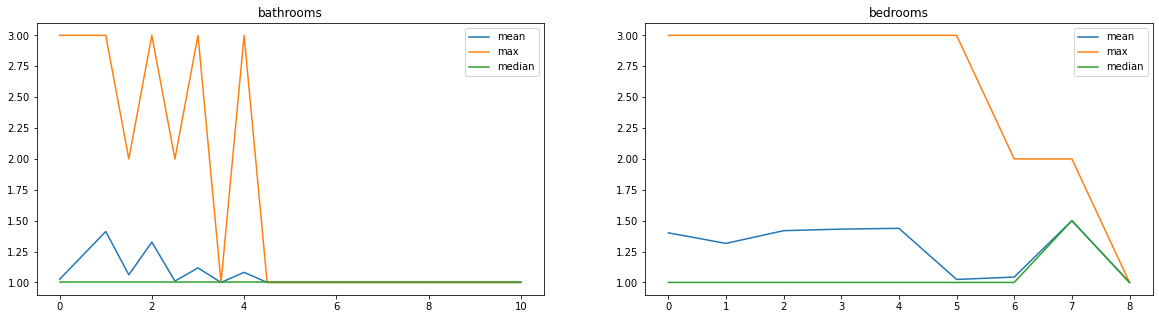

In [0]:
#зависимость кол-ва комнать от оценки
plt.figure(figsize = (20, 5))
plt.subplot(121)
bathrooms_stats = data.train.groupby('bathrooms').interest_level.agg(['mean', 'max', 'median'])
bedrooms_stats = data.train.groupby('bedrooms').interest_level.agg(['mean', 'max', 'median'])
plt.subplot(121)
for col in bathrooms_stats.columns: plt.plot(bathrooms_stats.index, bathrooms_stats[col], label = col)
plt.title('bathrooms')
plt.legend();
plt.subplot(122)
for col in bedrooms_stats.columns: plt.plot(bedrooms_stats.index, bedrooms_stats[col], label = col)
plt.legend()
plt.title('bedrooms');

In [0]:
for df in [data.train, data.test]:
    df['fraction_bathrooms'] = (round(df.bathrooms) != df.bathrooms).astype(np.uint8) #дробное число bathrooms
    df['bathrooms_is_0'] = (round(df.bathrooms) == 0).astype(np.uint8)
    df['bedrooms_is_0'] = (round(df.bedrooms) == 0).astype(np.uint8)

In [0]:
data.test.loc['17808', 'bathrooms'] = 1 #из условия train[(train.display_address == 'East 75th Street') & (train.price == 3700)]
data.train.loc['104459', 'bathrooms'] = 1 #из условия data.all[(data.all.street_address == '260 west 52 st.') & (data.all.price > 3300)]
data.test.loc['837', 'bathrooms'] = 2 #data.all[(data.all.street_address == '170 East 2nd Street') & (data.all.price > 4975)]
data.test.loc['22737', 'bathrooms'] = 2#data.all[(data.all.street_address == '305 East 86th Street') & (data.all.price > 4975)]

count    4.935200e+04
mean     3.830174e+03
std      2.206687e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64 count    7.465900e+04
mean     3.749033e+03
std      9.713092e+03
min      1.000000e+00
25%      2.495000e+03
50%      3.150000e+03
75%      4.100000e+03
max      1.675000e+06
Name: price, dtype: float64


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,day,month,is_weekend,count_date,is_uniq_date,time_from_first_created_per_manager,time_from_first_created,count_photos,count_photos_is_0,count_features,count_features_is_0,count_uniq_build_in_manage,mean_price_manager,max_price_manager,mim_price_manager,median_price_manager,unique_display_adress_per_manager,total_offer_per_manager,estimate_price_from_manager_id,price_minum_mean_manager_id,price_minus_median_manager_id,building_id_is_0,count_uniq_manage_in_build,mean_price_in_build,median_price_in_build,...,min_price_in_build,total_offer_per_build,estimate_price_from_build_id,price_minum_mean_build_id,price_minus_median_build_id,count_words_in_desc,count_words_capslock,office_in_desc,studio_in_desc,empty_desc,transport_desc,count_numeric_in_display_adress,count_managers_per_display_adress,unq_count_managers_per_display,mean_price_per_display_adress,median_price_per_display_adress,min_price_per_display_adress,max_price_per_display_adress,count_build_per_display_adress,unq_count_build_per_display,total_offer_per_display_adress,estimate_price_from_display_adress,price_minum_mean_display_adress,price_minus_median_display_adress,is_west,is_east,is_st,is_ave,is_pl,is_lane,is_terrace,is_drive,is_crescent,is_court,is_boulevard,is_road,is_broadway,fraction_bathrooms,bathrooms_is_0,bedrooms_is_0
53144,1.0,0,64f8e51f01a36ab0cd55fe9de2381306,2016-05-24 05:24:56,<p><a website_redacted,Madison,"[Doorman, Elevator, High Speed Internet]",40.7120,7060255,-73.9971,29ebd2f6553fbe12706a006a97349dd6,[],43,60 madison,1,1,5,0,1,0,4502501.0,-4518735.0,0,1,3,0,6,6223.5,15000,43,5000.0,7,8,0.006909,-6180.5,-4957.0,0,1,43.0,43.0,...,43,1,1.000000,0.0,0.0,4,0,0,0,0,0,0,2,2,1596.500000,1596.5,43,3150,2,2,2,0.026934,-1553.500000,-1553.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
87511,1.0,0,d992b617c630de9c7b903a54562682dc,2016-04-02 02:43:15,<p><a website_redacted,W 30th St.,[Elevator],40.7479,6813772,-73.9917,29ebd2f6553fbe12706a006a97349dd6,[https://photos.renthop.com/2/6813772_323b9438...,45,140 west 30th st,1,5,4,1,1,0,0.0,-16234.0,10,0,1,0,6,6223.5,15000,43,5000.0,7,8,0.007231,-6178.5,-4955.0,0,1,3272.5,3272.5,...,45,2,0.013751,-3227.5,-3227.5,4,0,0,0,0,0,1,12,7,5077.916667,4172.5,45,15000,12,6,12,0.008862,-5032.916667,-4127.5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


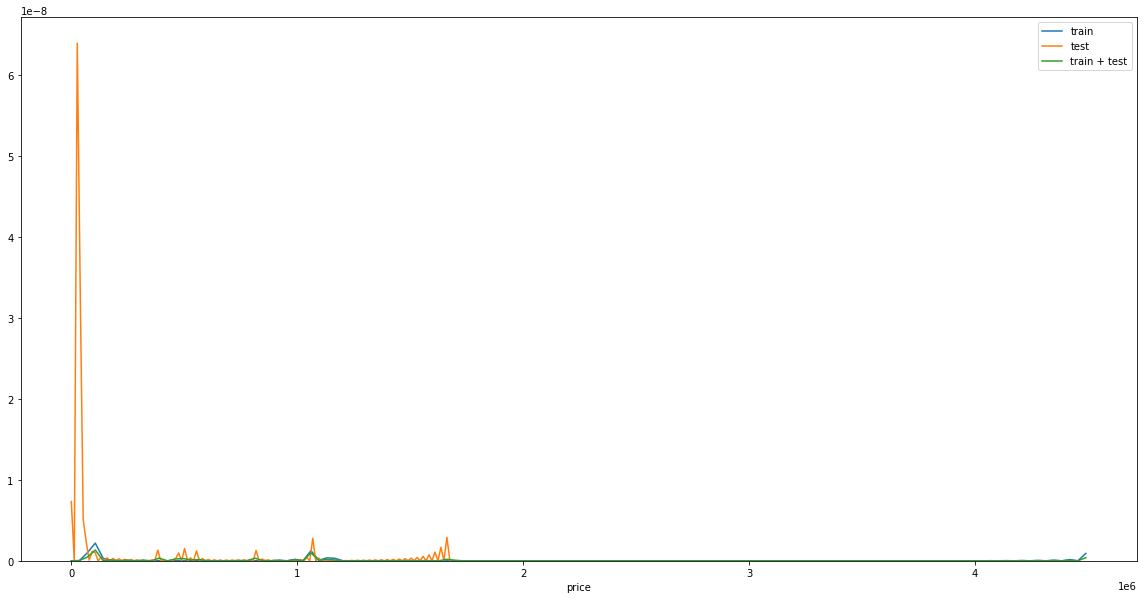

In [0]:
plt.figure(figsize = (20, 10))
sns.distplot(data.train.price, hist = False, label = 'train');
sns.distplot(data.test.price, hist = False, label = 'test');
sns.distplot(data.all.price, hist = False, label = 'train + test');
print(data.train.price.describe(), data.test.price.describe())
#прологорифмировать?
data.train[data.train.price < 100]#43 45? у одного менеджера

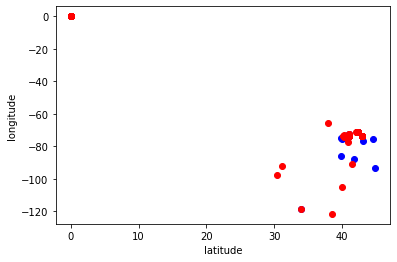

In [0]:
#необычные нули
plt.scatter(data.train.latitude, data.train.longitude, color = 'blue')
plt.scatter(data.test.latitude, data.test.longitude, color = 'red')
plt.xlabel('latitude')
plt.ylabel('longitude');
#нулевые знач

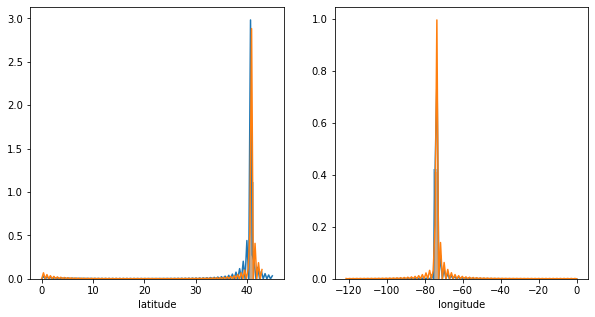

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
sns.distplot(data.train.latitude, ax = ax1, label = 'train')
sns.distplot(data.test.latitude, ax = ax1, label = 'test')
sns.distplot(data.train.longitude, ax = ax2, label = 'train')
sns.distplot(data.test.longitude, ax = ax2, label = 'test');

In [0]:
#!$ pip install -U googlemaps
#import googlemaps
#from datetime import datetime
#gmaps = googlemaps.Client(key = '')
#geocode_result = gmaps.geocode(adress)

In [0]:
#замена нулей в долготе и широте для трейна
idx = ['46941', '63688', '26304']
lat_long = [(40.7958, -73.9485), (40.7744, -73.9497), (40.7889 , -73.9756)]
for i, val in zip(idx, lat_long):
    data.train.loc[i, 'latitude'] = val[0]
    data.train.loc[i, 'longitude'] = val[1]


google_map = {2028: (40.659569, -74.000630),
37426: (40.602220, -73.974570),
39134: (40.741718, -73.979907),
49884: (40.751692, -73.941356),
66197: (40.789151, -73.975426),
69423: (40.801496, -73.962723),
70841: (40.723330, -73.994599),
76934: (40.798779, -73.960942),
85521: (40.755914, -73.965757),
106350: (40.681676, -73.933435)}

for key in google_map.keys():
    data.train.loc[str(key), 'latitude'] = google_map.get(key)[0]
    data.train.loc[str(key), 'longitude'] = google_map.get(key)[1]

for ind in data.train[(data.train.latitude < 10) & (data.train.longitude > -10)].index:
    print('------------------------------------------')
    print(f'ind: {ind} --', data.train.loc[ind, 'street_address'], '  ',data.all[data.all.street_address == data.train.loc[ind, 'street_address']][['display_address', 'street_address', 'latitude', 'longitude']])

In [0]:
#замена нулей в долготе и широте для теста
idx = ['21168', '32592', '85886', '87781', '91071', '93203', '100928', '101935', '108702', '109135']
lat_long = [(40.7322, -74.0019), (40.7596, -73.99), (40.7602, -73.9689), (40.6714, -73.9499),
            (40.7293, -73.9887), (40.79, -73.9747), (40.7254, -73.988), (40.7587, -73.9916),
            (40.765, -73.9879), (40.7751, -73.9481)]

for i, val in zip(idx, lat_long):
    data.test.loc[i, 'latitude'] = val[0]
    data.test.loc[i, 'longitude'] = val[1]

google_map = {'11348': (40.801248, -73.964754),
#'56248': 40.801248, -73.964754), 
#'63742': (40.801248, -73.964754),
'23825': (40.801248, -73.964754),
'28197': (40.725988, -73.986733),
'34487': (40.832724, -73.943047),
'43526': (40.763541, -73.979923),
'49362': (40.763644, -73.991716),
'51400': (40.734705, -73.998188),
'53736': (40.792839, -73.946096),
'58574': (40.671419, -73.950112),
'60891': (40.643206, -73.949708),
'65830': (40.800633, -73.959840),
'66326': (40.803314, -73.965951),
'67390': (40.729658, -73.979415),
'81060': (40.729646, -73.979439),
'103540': (40.763134, -73.976934),
'92660': (40.778994, -73.984244),
'89994': (40.763125, -73.976947),
'97386': (40.646057, -73.960670),
'104983': (40.675020, -73.955044),
'117661': (40.699696, -73.980052)
}

for key in google_map.keys():
    data.test.loc[str(key), 'latitude'] = google_map.get(key)[0]
    data.test.loc[str(key), 'longitude'] = google_map.get(key)[1]

for ind in data.test[(data.test.latitude < 10) & (data.test.longitude > -10)].index:
    print('------------------------------------------')
    print(f'ind: {ind} --', data.test.loc[ind, 'street_address'], '  ',data.all[data.all.street_address == data.test.loc[ind, 'street_address']][['display_address', 'street_address', 'latitude', 'longitude']])

In [0]:
def sphere_dist(latitude1, longitude1, latitude2, longitude2):
    return np.arccos(np.sin(latitude1) * np.sin(latitude2) +
                     np.cos(latitude1) * np.cos(latitude2) * np.cos(longitude2 - longitude1))


lat_stat = data.all.latitude.agg(['mean', 'median', 'max', 'min'])
long_stat = data.all.longitude.agg(['mean', 'median', 'max', 'min'])


for df in [data.train, data.test]:
    df['dist_to_central_park'] = sphere_dist(40.783, -73.9658, df.latitude, df.longitude) #до центрального парка
    df['dist_to_statue_of_liberty'] = sphere_dist(40.689167, -74.044583, df.latitude, df.longitude) #до статуи свободы
    df['dist_to_empire_state_building'] = sphere_dist(40.7484831, -73.9856715, df.latitude, df.longitude) #до эмпаир стейт билдинг
    df['dist_to_times_square'] = sphere_dist(40.758897, -73.9851471, df.latitude, df.longitude) #до тайм сквер
    df['dist_to_central_terminal'] = sphere_dist(40.752655, -73.977295, df.latitude, df.longitude) #до центрального вокзала

    #расстояние до среднего, медианного, макс, мин
    df['dist_to_mean'] = sphere_dist(lat_stat.get('mean'), long_stat.get('mean'), df.latitude, df.longitude)
    df['dist_to_median'] = sphere_dist(lat_stat.get('median'), long_stat.get('median'), df.latitude, df.longitude)
    df['dist_to_max'] = sphere_dist(lat_stat.get('max'), long_stat.get('max'), df.latitude, df.longitude)
    df['dist_to_min'] = sphere_dist(lat_stat.get('min'), long_stat.get('min'), df.latitude, df.longitude)
    
    #отдельные расстояния до среднего медианного макс мин
    df['latitude_to_mean'] = lat_stat.get('mean') - df.latitude
    df['latitude_to_median'] = lat_stat.get('median') - df.latitude
    df['latitude_to_max'] = lat_stat.get('max') - df.latitude
    df['latitude_to_min'] = lat_stat.get('min') - df.latitude
    
    df['longitude_to_mean'] = long_stat.get('mean') - df.latitude
    df['longitude_to_median'] = long_stat.get('median') - df.latitude
    df['longitude_to_max'] = long_stat.get('max') - df.latitude
    df['longitude_to_min'] = long_stat.get('min') - df.latitude

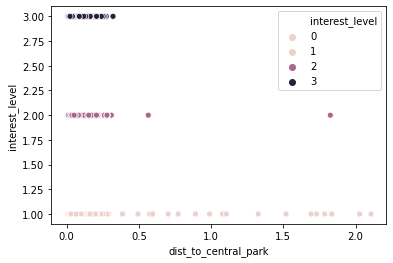

In [0]:
sns.scatterplot(data = data.train, x = 'dist_to_central_park', y = 'interest_level', hue = data.train.interest_level);

In [0]:
data.train.isnull().sum().sort_values()

bathrooms                     0
is_lane                       0
is_pl                         0
is_ave                        0
is_st                         0
                             ..
max_price_manager             0
mean_price_manager            0
count_uniq_build_in_manage    0
count_features                0
longitude_to_min              0
Length: 98, dtype: int64

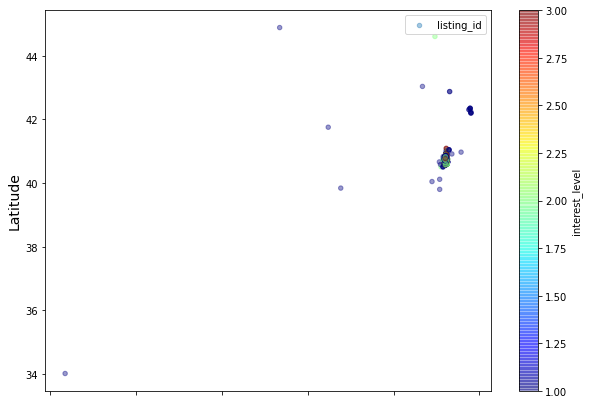

In [0]:
data.train.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4, 
        label = 'listing_id', figsize = (10,7),
				c = 'interest_level', cmap = plt.get_cmap('jet'), colorbar = True)
plt.ylabel('Latitude', fontsize = 14)
plt.xlabel('Longitude', fontsize = 14)
plt.legend() 
plt.show();
#все что вне нью-йорка поставить 0.8

In [0]:
#замена 0 badrooms на bathrooms на близкие значения
for ind in data.train[(data.train.bedrooms == 0) & (data.train.bathrooms == 0)].index:
    data.train.loc[ind, 'bathrooms'] = data.all[data.all.street_address == data.train.loc[ind, 'street_address']].bathrooms.median()
    data.train.loc[ind, 'bedrooms'] = data.all[data.all.street_address == data.train.loc[ind, 'street_address']].bedrooms.median()

for ind in data.test[(data.test.bedrooms == 0) & (data.test.bathrooms == 0)].index:
    data.test.loc[ind, 'bathrooms'] = data.all[data.all.street_address == data.test.loc[ind, 'street_address']].bathrooms.median()
    data.test.loc[ind, 'bedrooms'] = data.all[data.all.street_address == data.test.loc[ind, 'street_address']].bedrooms.median()

In [0]:
data.test[(data.test.bedrooms == 0) & (data.test.bathrooms == 0)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,day,month,is_weekend,count_date,is_uniq_date,time_from_first_created_per_manager,time_from_first_created,count_photos,count_photos_is_0,count_features,count_features_is_0,count_uniq_build_in_manage,mean_price_manager,max_price_manager,mim_price_manager,median_price_manager,unique_display_adress_per_manager,total_offer_per_manager,estimate_price_from_manager_id,price_minum_mean_manager_id,price_minus_median_manager_id,building_id_is_0,count_uniq_manage_in_build,mean_price_in_build,median_price_in_build,max_price_in_build,...,max_price_per_display_adress,count_build_per_display_adress,unq_count_build_per_display,total_offer_per_display_adress,estimate_price_from_display_adress,price_minum_mean_display_adress,price_minus_median_display_adress,is_west,is_east,is_st,is_ave,is_pl,is_lane,is_terrace,is_drive,is_crescent,is_court,is_boulevard,is_road,is_broadway,fraction_bathrooms,bathrooms_is_0,bedrooms_is_0,dist_to_central_park,dist_to_statue_of_liberty,dist_to_empire_state_building,dist_to_times_square,dist_to_central_terminal,dist_to_mean,dist_to_median,dist_to_max,dist_to_min,latitude_to_mean,latitude_to_median,latitude_to_max,latitude_to_min,longitude_to_mean,longitude_to_median,longitude_to_max,longitude_to_min
1964,0.0,0.0,6f0cfcbefc79784a962799aa13dcff4c,2016-06-11 04:55:18,Remarkable office opportunity located ...,2995 Ocean Pkwy,[],40.5779,7141774,-73.9675,2a7365e44e01278df84c6ab3a32a2cb4,[https://photos.renthop.com/2/7141774_1c94447b...,4500,2995 ocean pkwy,5,6,1,1,0,0.0,-6072157.0,15,0,0,1,1,4500.000000,4500,4500,4500.0,1,1,1.000000,0.000000,0.0,0,1,4500.000000,4500.0,4500,...,4500,1,1,1,1.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.205107,0.134402,0.171516,0.181828,0.175020,0.173325,0.174095,1.201673,1.293902,0.173211,0.1738,4.3056,-10.1499,-114.55179,-114.5557,-106.4262,-162.0659
4809,0.0,0.0,0,2016-06-21 06:41:11,,& 515 West 52nd Street,"[Doorman, Fitness Center, Cats Allowed]",40.7423,7193425,-73.9129,9556a2e6dd5f856dfaf77cd09fb8af38,[],2880,510 & 515 west 52nd st,1,6,0,1,0,6571594.0,-6942510.0,0,1,3,0,23,2728.520000,5800,1300,2750.0,23,25,1.055517,151.480000,130.0,1,1595,3363.348432,2895.0,60000,...,2880,1,1,1,1.000000,0.000000,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0.066614,0.141030,0.072704,0.073842,0.064946,0.061356,0.065295,1.363143,1.147338,0.008811,0.0094,4.1412,-10.3143,-114.71619,-114.7201,-106.5906,-162.2303
8693,0.0,0.0,d9821fbd38332385305d884872cfcf39,2016-06-15 05:06:54,Doctors office for rent on Doctors row...,435 Bay Ridge Pkwy,[],40.6305,7163717,-74.0239,6f63020874d0bac3287ec5cdf202e270,[https://photos.renthop.com/2/7163717_da2fb5bd...,1800,435 bay ridge pkwy,2,6,0,1,0,6053332.0,-6418453.0,5,0,0,1,22,2160.714286,3500,1500,2200.0,22,35,0.833058,-360.714286,-400.0,0,1,1800.000000,1800.0,1800,...,1800,1,1,1,1.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.162987,0.062094,0.123881,0.133991,0.130549,0.130342,0.129479,1.207368,1.231052,0.120611,0.1212,4.2530,-10.2025,-114.60439,-114.6083,-106.4788,-162.1185
9325,0.0,0.0,5afe2b9a096204ebce976e5546be668e,2016-06-17 04:38:04,,Pineapple St,[],40.6983,7176629,-73.9929,d9363a45ba9c52f38d43f473c4dd4261,[],1995,75 pineapple st,4,6,0,1,0,2682935.0,-6589523.0,0,1,0,1,13,2719.000000,3900,1500,2705.0,12,20,0.733726,-724.000000,-710.0,0,28,2044.404762,2072.5,2250,...,2395,20,3,20,0.955002,-94.000000,-105.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0.088886,0.051935,0.050694,0.061085,0.056522,0.056085,0.055466,1.279361,1.170979,0.052811,0.0534,4.1852,-10.2703,-114.67219,-114.6761,-106.5466,-162.1863
10660,0.0,0.0,6d4dc61829e0abf61222112b701f27e7,2016-06-12 12:57:39,,St Nicholas Ave,[],40.8430,7151571,-73.9380,6f3b9d0de5528e408b621c9f8321313f,[],2053,1224 st nicholas ave,6,6,1,1,0,4522960.0,-6187498.0,0,1,0,1,13,2686.058824,6070,1450,2780.0,12,17,0.764317,-633.058824,-727.0,0,4,1751.500000,1751.5,2053,...,4200,20,8,20,0.80744

In [0]:
#везде должен быть 0.5 санузла, хотя можно посмотреть по описанию, значения
for idx in data.train[(data.train.bedrooms == 0) & (data.train.bathrooms == 0)].index:
    data.train.loc[idx, 'bathrooms'] = 0.5

for idx in data.test[(data.test.bedrooms == 0) & (data.test.bathrooms == 0)].index:
    data.test.loc[idx, 'bathrooms'] = 0.5

In [0]:
for df in [data.train, data.test]:
    df.price = df.price.replace(0, data.all[data.all.price != 0].price.median())
    df['price_Per_room'] = df.price / (df.bedrooms + df.bathrooms)
    df['rooms'] = df.bedrooms + df.bathrooms
    df['price_per_bedrooms'] = df.price_Per_room * df.bedrooms
    df['price_per_bathrooms'] = df.price_Per_room * df.bathrooms 

In [0]:
#слишком долго считаются 
#!pip install -q reverse_geocoder
#!pip install textblob
#import reverse_geocoder as revgc

#data.train['polarity_desc'] = data.train.description.apply(lambda x: textblob.TextBlob(x).correct().sentiment.polarity)
#data.test['polarity_desc'] = data.test.description.apply(lambda x: textblob.TextBlob(x).correct().sentiment.polarity)

#data.train[['latitude', 'longitude']].apply(lambda x: revgc.search([x.latitude, x.longitude])[0].get('admin2'), axis = 1).to_csv('train_admin.csv')
#data.test[['latitude', 'longitude']].apply(lambda x: revgc.search([x.latitude, x.longitude])[0].get('admin2'), axis = 1).to_csv('test_admin.csv')

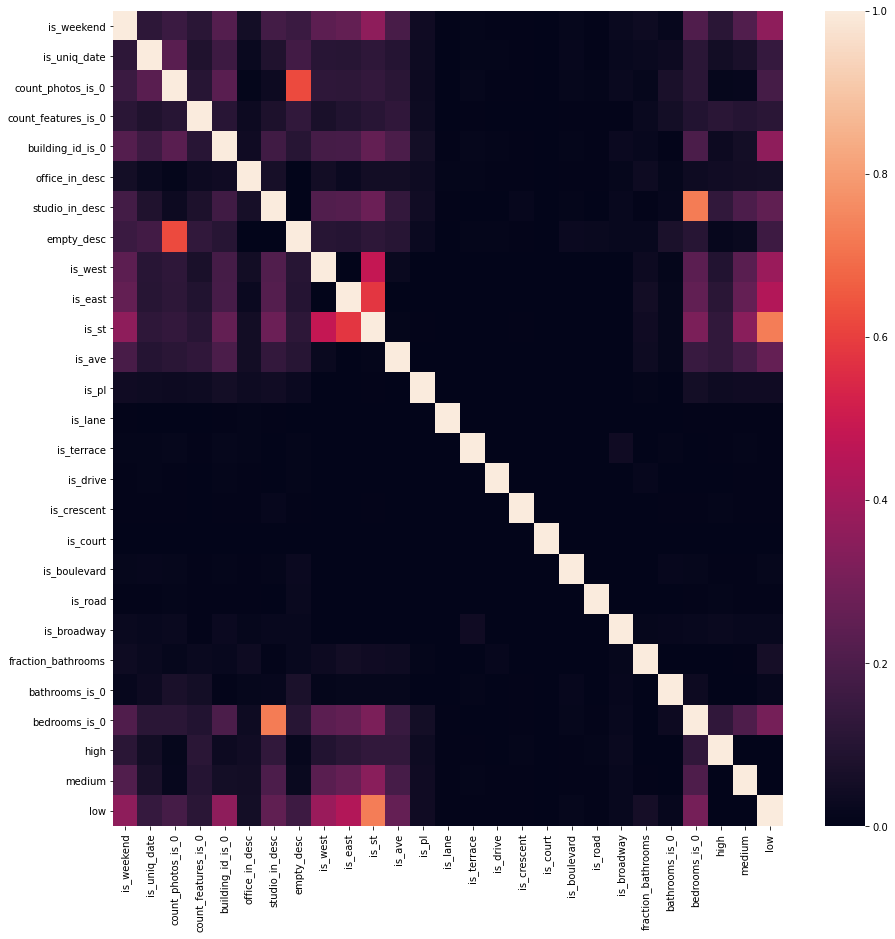

In [0]:
dice_data = pd.DataFrame()
for col in data.train.columns:
    try:
        if len(data.train[col].unique()) == 2:
            dice_data[col] = data.train[col]
    except TypeError as exc:
        continue

dice_data['high'] = (data.train.interest_level == 3).astype(np.uint8)
dice_data['medium'] = (data.train.interest_level == 2).astype(np.uint8)
dice_data['low'] = (data.train.interest_level == 1).astype(np.uint8)


def dice(series1, series2):
    intersection = np.sum(series1 * series2)                  
    return 2 * intersection  / (np.sum(series1) + np.sum(series2))

dice_coefs = pd.DataFrame(index = dice_data.columns, columns = dice_data.columns)   
for i in dice_coefs.index:
    for j in dice_coefs.columns:
        dice_coefs.loc[i, j] = dice(dice_data[i], dice_data[j])

for col in dice_coefs.columns: dice_coefs[col] = dice_coefs[col].astype(np.float32)

plt.figure(figsize = (15, 15))
sns.heatmap(dice_coefs);
#если студия и спален 0, нет фото и пустое описание

In [0]:
def bayes_variable(data: 'pd.DataFrame', x: str, y: str) -> None:
    l = len(data)
    priory = {val: len(data[data[x] == val])/ l for val in data[x].unique()}
    group = data.groupby(x)[y].value_counts()
    for i in data[y].unique():
        full = sum([val * group.get((key, i), 0) / group.get(key).sum() for key, val in priory.items()])
        for key in priory.keys():
            posterior = group.get((key, i), 0) / group.get(key).sum() * priory.get(key)
            print(f'вероятность {y} = {i} при {x} = {key} : {posterior}')
            
bayes_variable(data = data.train, x = 'is_st', y = 'interest_level')
#наверное тк улиц и 1 преобладает

вероятность interest_level = 2 при is_st = 0 : 0.05930863997406386
вероятность interest_level = 2 при is_st = 1 : 0.1682201329226779
вероятность interest_level = 1 при is_st = 0 : 0.1713810990436051
вероятность interest_level = 1 при is_st = 1 : 0.5233019938401686
вероятность interest_level = 3 при is_st = 0 : 0.024315124007132434
вероятность interest_level = 3 при is_st = 1 : 0.05347301021235209


In [0]:
def replace_words(string):
    keyword_processor = KeywordProcessor()
    keyword_dict = {
          'concierge': ['doorman'],
          'clean': ['cleaning'],
          'pet': ['dogs', 'dog', 'cats', 'cat', 'pets'],
          'elev': ['elevator'],
          'full': ['fully'],
          'floor': ['floors'],
          'view': ['views'],
          'closet': ['closets'],
          'children': ['childrens'],
          'ceiling': ['ceilings'],
          'bedroom': ['bedboorms'],
          'bath': ['bathroom', 'bathrooms', 'baths'],
          'bedroom': ['bedrooms'],
          'wifi': ['wi-fi'],
          'photo': ['photos'],
          'roofdeck': ['roof'],
          'pay': ['fee', 'payment'],
          'dry': ['dryer'],
          ' ': ['/', '-']
    }
    keyword_processor.add_keywords_from_dict(keyword_dict)
    return keyword_processor.replace_keywords(string.lower())


data.train['str_features'] = data.train.features.apply(lambda s: replace_words(' '.join(s)))
data.test['str_features'] = data.test.features.apply(lambda s: replace_words(' '.join(s)))

cv = TfidfVectorizer(min_df = 40, stop_words = 'english')
cv.fit(data.all.str_features.astype('U'))

svd = TruncatedSVD(n_components = 100, n_iter = 5, random_state = 5)
svd.fit(cv.transform(data.all.str_features).todense())


trn = pd.DataFrame(svd.transform(cv.transform(data.train.str_features).todense()), columns = [f'svd_{i}' for i in range(100)], index =  data.train.index)
tst = pd.DataFrame(svd.transform(cv.transform(data.test.str_features).todense()), columns = [f'svd_{i}' for i in range(100)], index =  data.test.index)

In [0]:
_train = pd.concat([data.train, trn], axis = 1)
_test = pd.concat([data.test, tst], axis = 1)

In [0]:
import numpy as np

def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    return -1.0 / rows * vsota

In [67]:
drops_col  = 'str_features building_id created description display_address features manager_id photos street_address interest_level'
feats = [col for col in data.train.columns if col not in drops_col.split(' ')] 


models = []
probas = []
scores = []
n_splits = 10

kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 2911)
oof_preds = np.zeros((data.train.shape[0], 3))
sub_preds = np.zeros((data.test.shape[0], 3))
feature_importance_df = pd.DataFrame()


folds = kf.split(data.train, data.train.interest_level.values)
                               
common_logloss = 0

for n_fold, (trn_idx, val_idx) in enumerate(folds):
    
    trn_x, trn_y = data.train[feats].iloc[trn_idx], data.train.interest_level.iloc[trn_idx]
    val_x, val_y = data.train[feats].iloc[val_idx], data.train.interest_level.iloc[val_idx]
    

    clf = lgbm.LGBMClassifier(max_depth = 30, n_jobs = -1,  metric = 'multi_logloss',
                              num_leaves = 10, objective = 'multiclass', boosting_type = 'gbdt',
                         learning_rate = 0.01, 
                         num_round = 1000000, 
                         random_state = 4112, 
                        bagging_fraction = 1.0, 
                        feature_fraction = 0.05,
                        lambda_l1 = 4.972,
                        lambda_l2 = 2.276,
                         )
    
    clf.fit(trn_x, trn_y, eval_set = [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric = 'multi_logloss', verbose = 1000, early_stopping_rounds = 3000,
            #categorical_feature = cat
            )
    
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)
    sub_preds += clf.predict_proba(data.test[feats], num_iteration = clf.best_iteration_) / kf.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df['feature'] = trn_x.columns
    fold_importance_df['importance'] = clf.feature_importances_
    fold_importance_df['fold'] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, log_loss(val_y, oof_preds[val_idx])))
    common_logloss += log_loss(val_y, oof_preds[val_idx])
    probas += [sub_preds]

print('common logloss: %.6f' % (common_logloss / n_splits))

Training until validation scores don't improve for 3000 rounds
[1000]	training's multi_logloss: 0.602483	valid_1's multi_logloss: 0.619323
[2000]	training's multi_logloss: 0.56516	valid_1's multi_logloss: 0.591551
[3000]	training's multi_logloss: 0.54309	valid_1's multi_logloss: 0.578062
[4000]	training's multi_logloss: 0.527	valid_1's multi_logloss: 0.570059
[5000]	training's multi_logloss: 0.51412	valid_1's multi_logloss: 0.564675
[6000]	training's multi_logloss: 0.503363	valid_1's multi_logloss: 0.560879
[7000]	training's multi_logloss: 0.493739	valid_1's multi_logloss: 0.558134
[8000]	training's multi_logloss: 0.4851	valid_1's multi_logloss: 0.556069
[9000]	training's multi_logloss: 0.477118	valid_1's multi_logloss: 0.554251
[10000]	training's multi_logloss: 0.469652	valid_1's multi_logloss: 0.552793
[11000]	training's multi_logloss: 0.46261	valid_1's multi_logloss: 0.551573
[12000]	training's multi_logloss: 0.456101	valid_1's multi_logloss: 0.550717
[13000]	training's multi_loglos

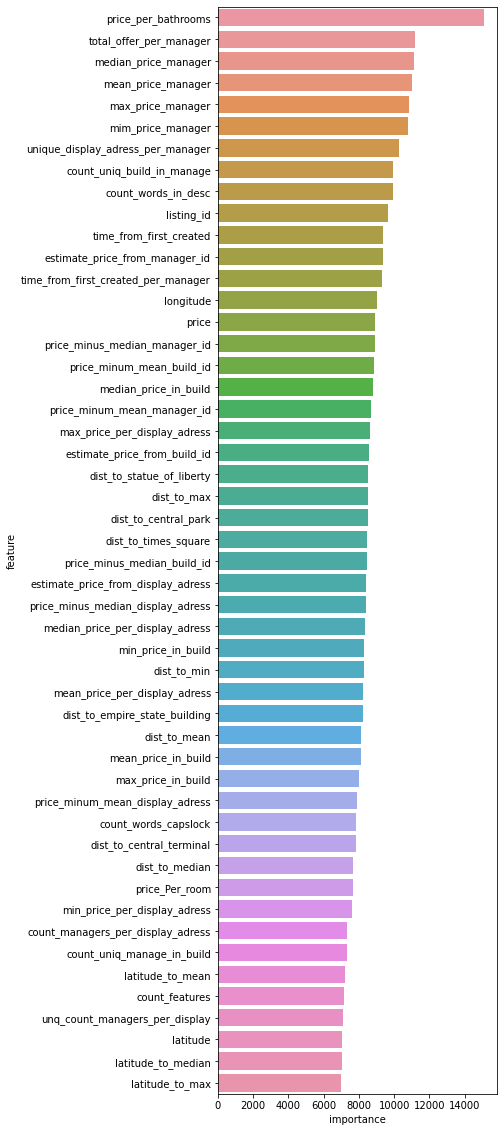

In [88]:
plt.figure(figsize = (5, 20))
_fold_importance_df = fold_importance_df.groupby('feature').sum().sort_values(by = 'importance', ascending = False)[:50]
sns.barplot(x = 'importance', y = _fold_importance_df.index, data = _fold_importance_df);

In [0]:
pd.DataFrame({
    'listing_id': data.test.listing_id,
    'high': sub_preds[:, 2],
    'medium': sub_preds[:, 1],
    'low': sub_preds[:, 0], 
}).to_csv('submit.csv', index = False)